In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Dict, List, TypedDict

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from utils import DATADIR, NAN_THRESHOLD, AdjacencyMethod, GraphEvent, load_data
from utils.graph import Graph

In [3]:
class EventData(TypedDict):
    raw: pd.DataFrame
    graphs: Dict[AdjacencyMethod, Graph]
    cutoff_rigidity: Dict[str, float]
    intensity: str


def load_events() -> Dict[str, EventData]:
    def load_intensity(file_path: Path) -> str:
        with open(file_path, "r") as f:
            intensity = f.read().strip()
        return intensity

    def load_cutoff_rigidity(file_path: Path) -> Dict[str, float]:
        if not file_path.exists():
            return {}

        rigidity = {}
        with open(file_path, "r") as f:
            for line in f:
                station, value = line.strip().split(",")
                rigidity[station] = float(value)
        return rigidity

    event_files = list(DATADIR.glob("*"))

    # Datetime is already parsed to datetime
    events: Dict[str, EventData] = {
        f.name: EventData(
            raw=load_data(f / "all.txt").set_index("datetime"),
            intensity=load_intensity(f / "intensity.txt"),
            graphs={},
            cutoff_rigidity=load_cutoff_rigidity(f / "cutoff_rigidity.txt"),
        )
        for f in event_files
        if f.is_dir()
    }

    return events

In [4]:
events = load_events()

## Preprocess DataFrames

Somes events have 2-min resolution (we download them for 1-min though), so we decided to standardize all events to 2-min. And, apparently, the data cannot have any NaN value

In [6]:
def invalid_stations(station_df: pd.DataFrame, use_threshold: bool) -> List[str]:
    """Check if a station has less than NAN_THRESHOLD percentage of NaN values."""
    nan_ratios = station_df.isna().mean()

    if use_threshold:
        invalid_stations = nan_ratios[nan_ratios >= NAN_THRESHOLD].index.tolist()
    else:
        invalid_stations = nan_ratios[nan_ratios > 0].index.tolist()

    return invalid_stations

In [7]:
# Fill data preprocessing
for event_name, data in events.items():
    df = data["raw"]

    # Drop stations with too many NaNs
    stations_to_drop = invalid_stations(df, use_threshold=False)
    df = df.drop(columns=stations_to_drop)

    # Resample to 2-minute intervals using median
    events[event_name]["raw"] = df.resample("2min").median()

## Create graphs

In [8]:
for event_date, data in events.items():
    for method in AdjacencyMethod:
        df = data["raw"].reset_index(drop=True)
        graph_event = GraphEvent(
            data=df,
            metadata={
                "event_date": event_date,
                "intensity": data["intensity"],
                "cutoff_rigidity": data["cutoff_rigidity"],
            },
        )

        events[event_date]["graphs"][method] = graph_event.get_graph_networkx(
            method
        )


## Draw graphs

In [9]:
for event_date, data in events.items():
    print(f"Event: {event_date}")
    for method, graph in data["graphs"].items():
        print(f"  Method: {method.name}, Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")

Event: 2024-05-10
  Method: CORRELATION, Nodes: 25, Edges: 300
  Method: COSINE, Nodes: 25, Edges: 300
  Method: MANHATTAN, Nodes: 25, Edges: 300
  Method: MINKOWSKI, Nodes: 25, Edges: 300
Event: 2024-03-24
  Method: CORRELATION, Nodes: 27, Edges: 351
  Method: COSINE, Nodes: 27, Edges: 351
  Method: MANHATTAN, Nodes: 27, Edges: 351
  Method: MINKOWSKI, Nodes: 27, Edges: 351
Event: 2023-04-23
  Method: CORRELATION, Nodes: 27, Edges: 351
  Method: COSINE, Nodes: 27, Edges: 351
  Method: MANHATTAN, Nodes: 27, Edges: 351
  Method: MINKOWSKI, Nodes: 27, Edges: 351


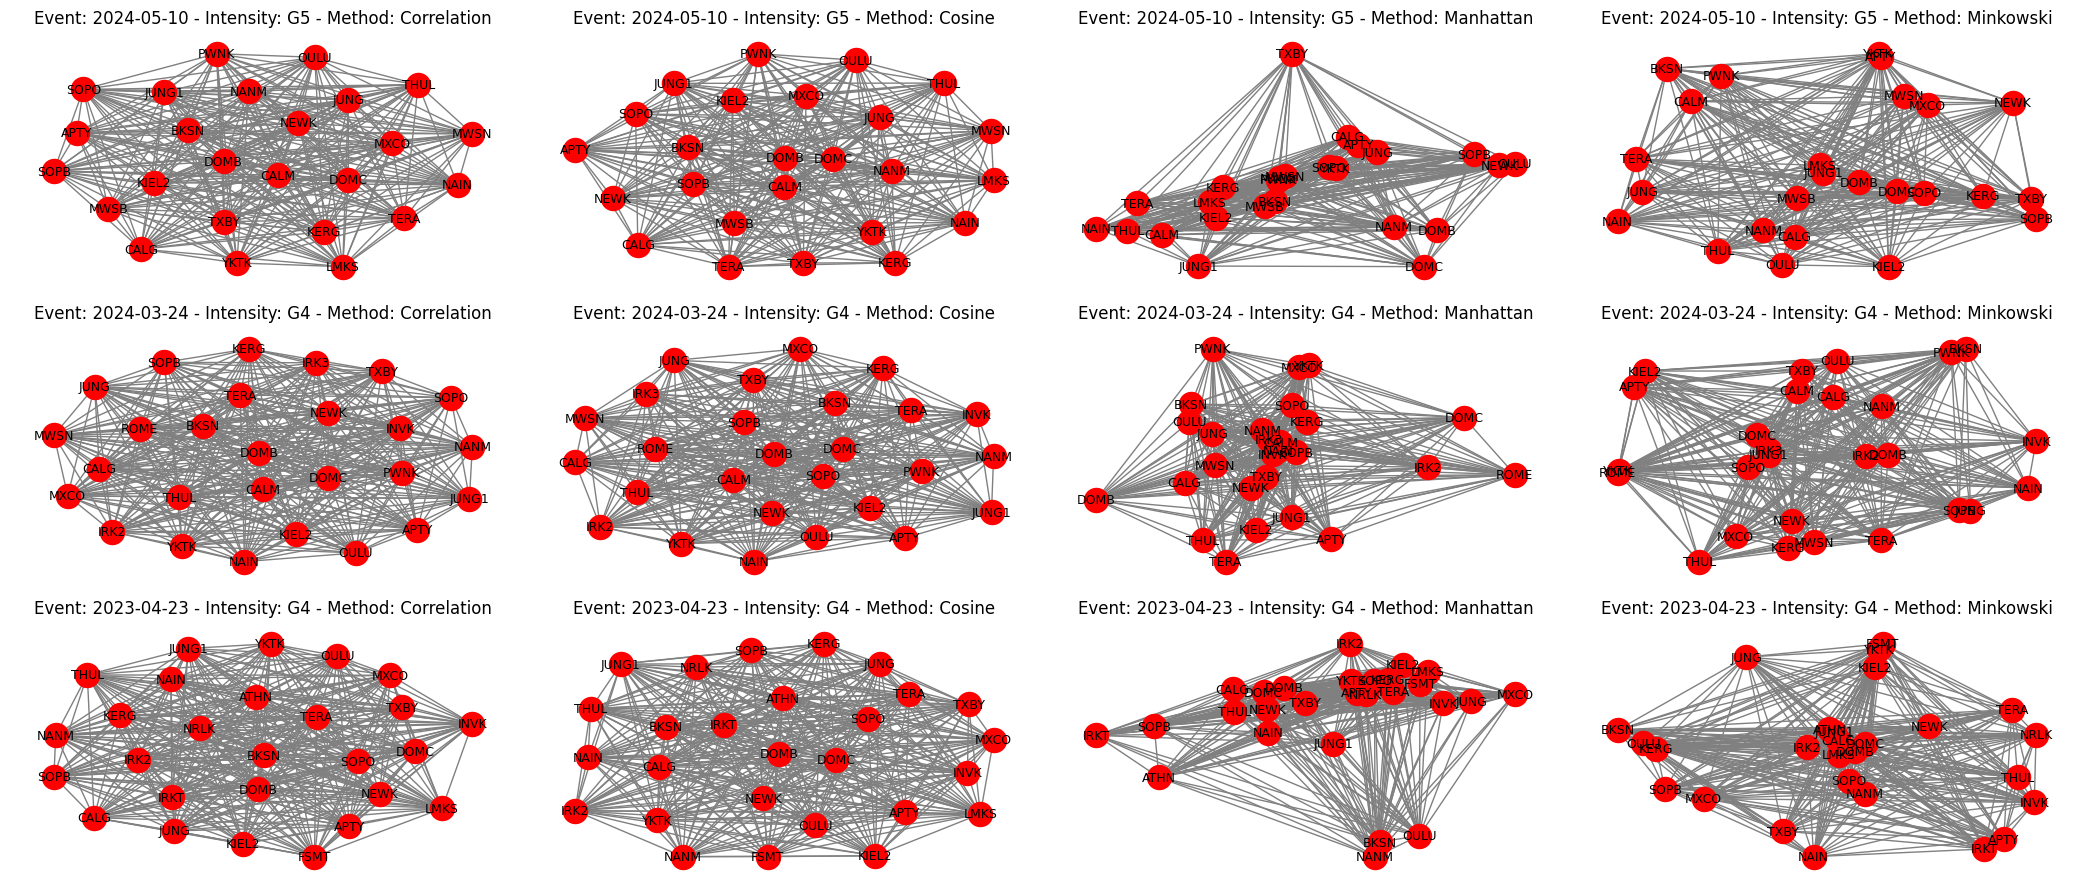

In [10]:
plot_grid = [3, 4]

fig, axes = plt.subplots(*plot_grid, figsize=(21, 9))
axes = axes.flatten()
i = 0

for event_date, data in events.items():
    for method, graph in data["graphs"].items():
        ax = axes[i]
        i += 1

        graph = data["graphs"][method]
        pos = nx.spring_layout(graph, weight="weight", seed=42)

        # Another layout option
        # pos = nx.kamada_kawai_layout(graph, weight="weight")

        nx.draw(
            graph,
            pos,
            ax=ax,
            with_labels=True,
            node_size=300,
            font_size=9,
            font_color="black",
            node_color="red",
            edge_color="gray",
        )
        ax.set_title(f"Event: {event_date} - Intensity: {data['intensity']} - Method: {method.name.title()}")

fig.tight_layout()
plt.show()

In [11]:
graph.graph

{'metadata_event_date': '2023-04-23',
 'metadata_intensity': 'G4',
 'metadata_cutoff_rigidity': {}}